In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import kurtosis, skew
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/econ-data/korea_data.xlsx


# Loading and Cleaning the Data

In [3]:
df = pd.read_excel("/kaggle/input/econ-data/korea_data.xlsx", parse_dates=True, index_col=0) # Reading in our data
df.index = df.index.strftime("%Y") # Changing the format of the date to better suit our needs

In [4]:
# Changing the column names to something easier to use
COLUMN_NAMES = {'Unemployment, total (% of total labor force) (national estimate)':'unemployment',
                'GDP growth (annual %)': 'gdp_growth',
                'Gross capital formation (% of GDP)':'gross_capital_formation',
                'Population growth (annual %)':'pop_growth', 
                'Birth rate, crude (per 1,000 people)':'birth_rate',
                'Broad money growth (annual %)':'broad_money_growth',                
                'Final consumption expenditure (% of GDP)':'final_consum_gdp',
                'Final consumption expenditure (annual % growth)':'final_consum_growth',
                'General government final consumption expenditure (annual % growth)':'gov_final_consum_growth',
                'Gross capital formation (annual % growth)':'gross_cap_form_growth',
                'Households and NPISHs Final consumption expenditure (annual % growth)':'hh_consum_growth'}
df.rename(columns=COLUMN_NAMES, inplace=True)

In [5]:
# This dataset assigns the value '..' for any NA values
df.replace('..', 'nan', inplace=True)

# Checking for and accounting for NA values
print(df.isna().any())

gdp_growth                 False
gross_capital_formation    False
pop_growth                 False
birth_rate                 False
broad_money_growth         False
final_consum_growth        False
gov_final_consum_growth    False
gross_cap_form_growth      False
hh_consum_growth           False
unemployment               False
dtype: bool


In [6]:
# Checking for any categorical data
print(df.dtypes)

gdp_growth                 float64
gross_capital_formation    float64
pop_growth                 float64
birth_rate                  object
broad_money_growth         float64
final_consum_growth        float64
gov_final_consum_growth    float64
gross_cap_form_growth      float64
hh_consum_growth           float64
unemployment               float64
dtype: object


In [7]:
# Removing rows from the birth_rate column with categorical data
rows_with_strings = df['birth_rate'].apply(lambda x: isinstance(x, str))

# Drop rows containing strings in 'Column1'
df = df.drop(df[rows_with_strings].index)
df = df.astype(float)

print(df.dtypes)

gdp_growth                 float64
gross_capital_formation    float64
pop_growth                 float64
birth_rate                 float64
broad_money_growth         float64
final_consum_growth        float64
gov_final_consum_growth    float64
gross_cap_form_growth      float64
hh_consum_growth           float64
unemployment               float64
dtype: object


# Some Basic Data Exploration

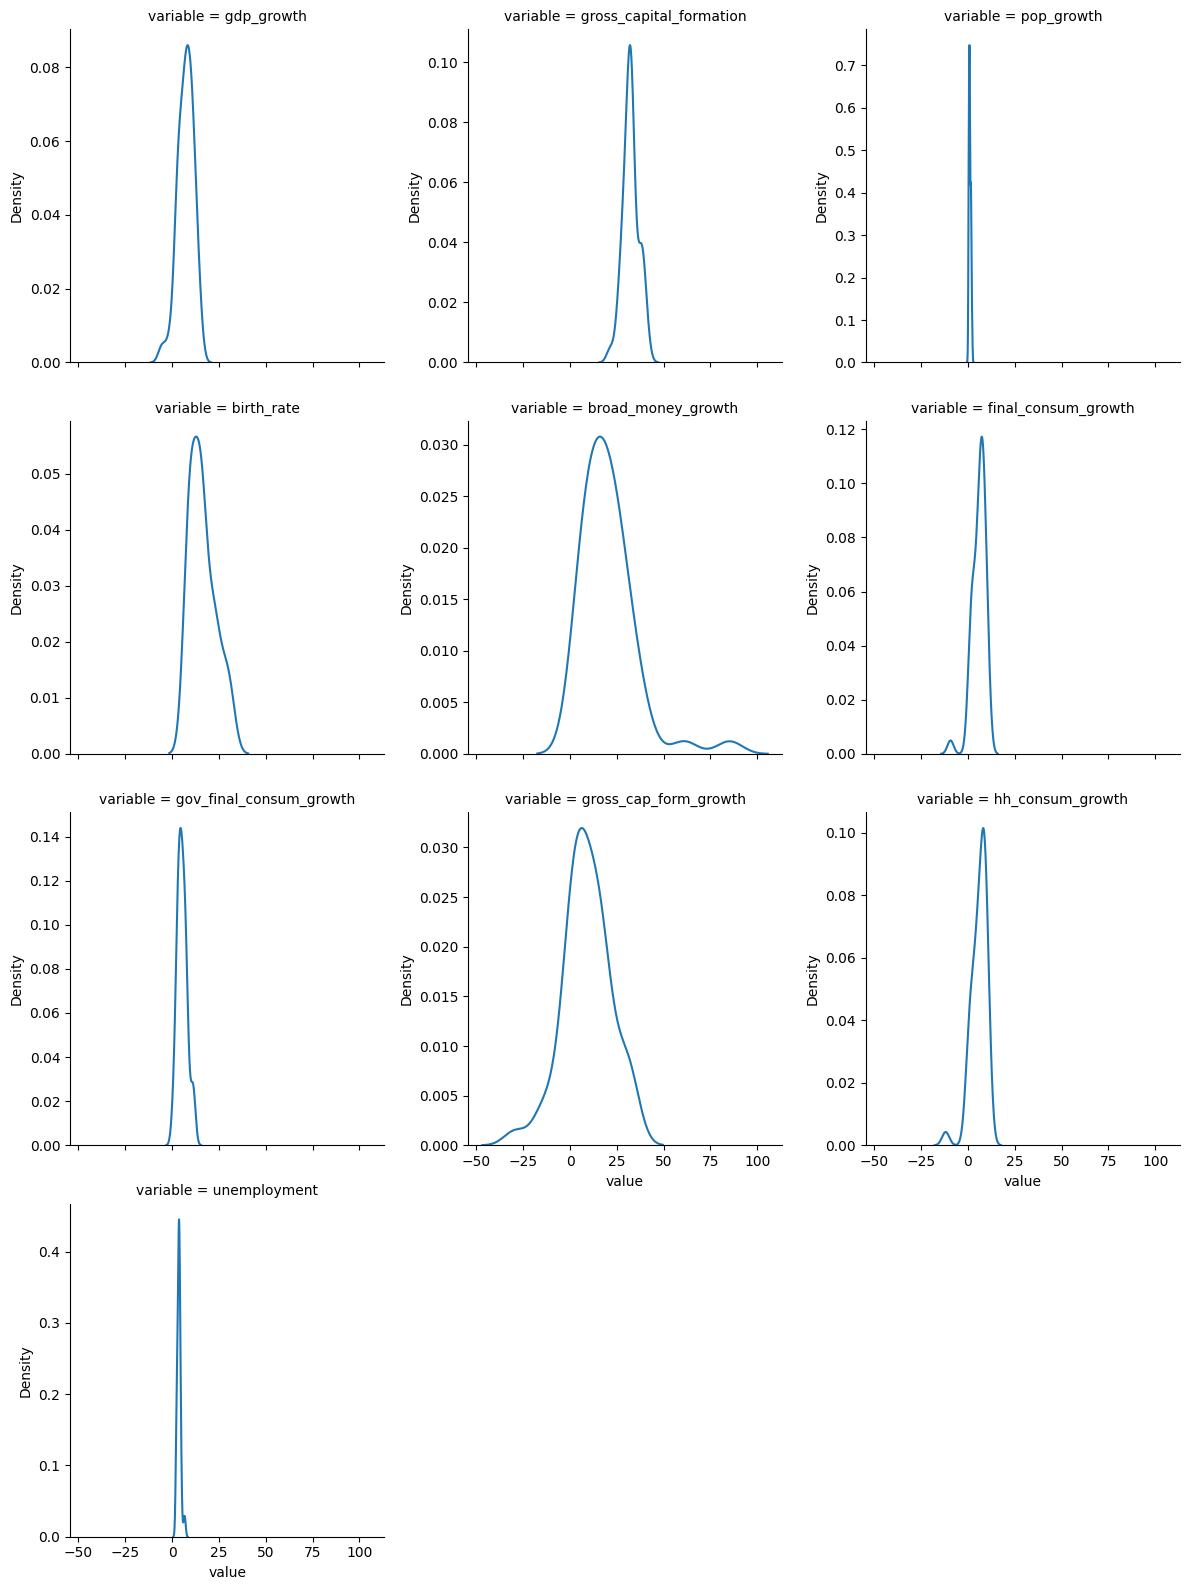

In [8]:
grid = sns.FacetGrid(df.melt(), col="variable", col_wrap=3, height=4, sharey=False)

# Map KDE plots to each FacetGrid
grid.map(sns.kdeplot, "value")

At Face Value, most of the data columns look to be fairly normally distributed with little skew, however, let's try to find the kurtosis and skew of each column to quantify it better

In [9]:
kurt = kurtosis(df)
skw = skew(df)

kurtosis_and_skew = pd.DataFrame({
    "kurtosis": kurt,
    "skew": skw
}, index=df.columns)

kurtosis_and_skew

,kurtosis,skew
gdp_growth,0.415400,-0.550852
gross_capital_formation,0.078977,0.028857
pop_growth,-0.629289,0.550508
birth_rate,-0.514789,0.707953
broad_money_growth,6.716502,2.162606
final_consum_growth,4.331185,-1.553820
gov_final_consum_growth,-0.003416,0.566269
gross_cap_form_growth,0.732614,-0.343286
hh_consum_growth,4.549210,-1.652374
unemployment,2.064779,0.990453


<Axes: >

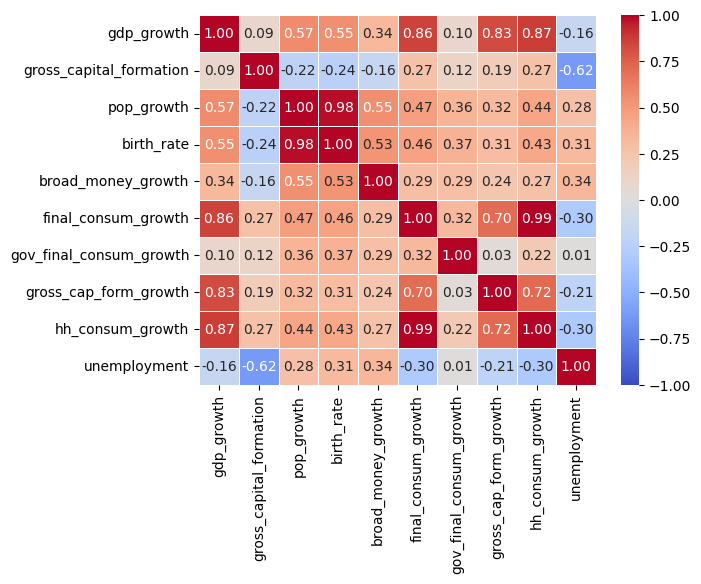

In [10]:
# Looking at the Correlation between different variables
df_corr = df.corr()
sns.heatmap(df_corr, annot=True, cmap="coolwarm", linewidths=0.5, fmt=".2f", vmin=-1, vmax=1)

Collinearity, in the context of statistics and linear regression, refers to a high degree of correlation between two or more predictor variables in a multiple regression model. In other words, it indicates that some independent variables in a regression model are highly correlated with each other. This high correlation can cause issues in the model estimation and interpretation.

The correlation matrix above shows several variables which have a near perfect correlation. To better understand the effects and strength of correlation between these 

In [38]:
# Creating a function to get an indicator of how well your model performs
def score_model(model, x_train, y_train, x_test, y_actual):
    model.fit(x_train, y_train)
    y_predict = model.predict(x_test)
    return r2_score(y_actual, y_predict)

# Random Forest Analysis and Prediction


In [40]:
# Splitting up the data into trains and tests
X = df.drop('gdp_growth', axis=1)
Y = df['gdp_growth']
x_train, x_test, y_train, y_actual = train_test_split(X, Y)

x_train.sort_index(inplace=True)
y_train.sort_index(inplace=True)
x_test.sort_index(inplace=True)
y_actual.sort_index(inplace=True)

# Finding out the best parameters for our model
for estimator_num in [1, 10, 20, 50, 100, 500, 1000, 5000, 10000]:
    model = RandomForestRegressor(n_estimators=estimator_num)
    model_score = score_model(model, x_train, y_train, x_test, y_actual)
    print(f"{estimator_num}: {model_score}")

1: 0.5140529951054158
10: 0.7282503126412285
20: 0.7607826105852287
50: 0.7543911881500097
100: 0.7548514864038529
500: 0.7856114707641
1000: 0.7807857262832087
5000: 0.7765287516856165
10000: 0.7751304961754865


The r-squared value tells us what percentage of the data can be accounted for by our model. i.e the higher our r-squared value, the better our model


After running the cell multiple times, we can observe a consistent pattern: the r-squared value for the number of estimators tends to plateau and, in some cases, decrease after surpassing 500 iterations. So, it can be concluded that 500 is the best value for the number of estimators to use

In [52]:
final_model = RandomForestRegressor(n_estimators=500)
final_model.fit(x_train, y_train)

y_predict = final_model.predict(x_test)

In [50]:
# Evaluating our model
r2_value = r2_score(y_actual, y_predict)
mae = mean_absolute_error(y_actual, y_predict)
mse = mean_squared_error(y_actual, y_predict)

print(f"r2_value: {r2_value}")
print(f"mae: {mae}")
print(f"mse: {mse}")

r2_value: 0.7568500471917844
mae: 1.8232877671841843
mse: 5.421123012743401


(-20.0, 20.0)

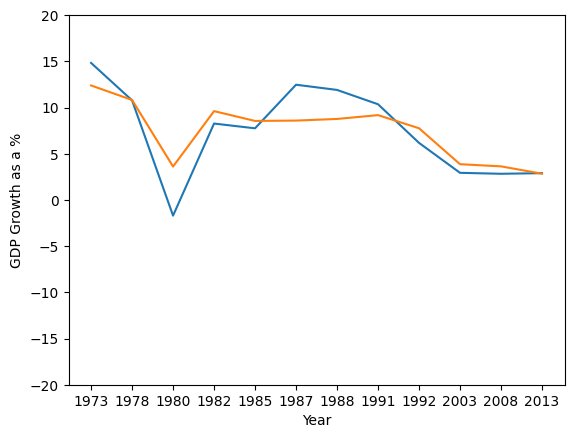

In [71]:
# Plotting the actual values for gdp_growth vs. the predicted values
sns.lineplot(data=y_actual)
sns.lineplot(data=y_predict)

plt.ylabel("GDP Growth as a %")
plt.ylim(-20, 20)

'Mean of Residuals: -0.01003478859614156'

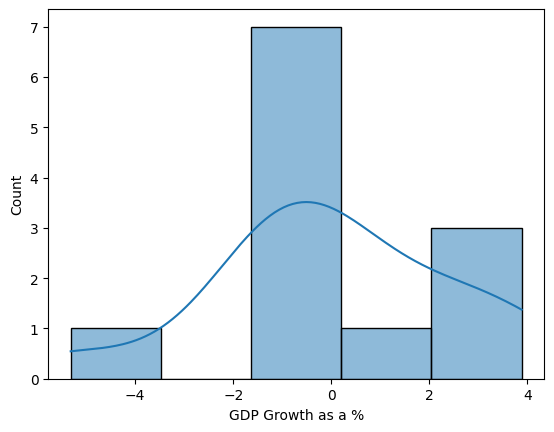

In [74]:
# Looking at the distribution of residuals
residuals = y_actual - y_predict
sns.histplot(residuals, kde=True)

plt.xlabel("GDP Growth as a %")
display("Mean of Residuals: " + str(residuals.mean()))

Our results are promising with a relatively high r-squared score and low values for both mean absolute error and mean squared error. The metrics show that 75.6% of the data is accounted for by our model. With testing for different parameters earlier on in the experiment, we were also able to lower errors and maximize model accuracy. The residuals are also centered between -2 and 0%, showing a stable and accurate model.